In [2]:
import pandas as pd
import os, re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import datetime
from tensorflow.keras import layers, models

In [3]:
def load_images(path="coral_image_jpg"):
    train_folder = os.path.join(os.getcwd(), path, "train")
    test_folder = os.path.join(os.getcwd(), path, "test")
    
    X_train, X_test, Y_train, Y_test = [], [], [], []
    
    # Loading images from train folder to X_train and label to Y_train
    train_count = 0
    for image_fname in os.listdir(train_folder):
        image_re = re.match(r'([0-9]+)_([0-9]+)\.jpg', image_fname)
        if not image_re:
            print(f"Filename {image_fname} does not match the expected pattern.")
            continue
        
        image_path = os.path.join(train_folder, image_fname)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
        
        try:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except cv2.error as e:
            print(f"Error converting image: {image_path}. Error: {e}")
            continue
        
        label = int(image_re.group(2))  # Convert label to integer
        
        X_train.append(image_rgb)
        Y_train.append(label)
        train_count += 1
        if train_count % 1000 == 0:
            print(f"Loaded {train_count} training images.")
    print("Loaded train folder")
    
    # Loading images from test folder to X_test and label to Y_test
    test_count = 0
    for image_fname in os.listdir(test_folder):
        image_re = re.match(r'([0-9]+)_([0-9]+)\.jpg', image_fname)
        if not image_re:
            print(f"Filename {image_fname} does not match the expected pattern.")
            continue
        
        image_path = os.path.join(test_folder, image_fname)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
        
        try:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except cv2.error as e:
            print(f"Error converting image: {image_path}. Error: {e}")
            continue
        
        label = int(image_re.group(2))  # Convert label to integer
        
        X_test.append(image_rgb)
        Y_test.append(label)
        test_count += 1
        if test_count % 1000 == 0:
            print(f"Loaded {test_count} testing images.")
    print("Loaded test folder")
    
    return X_train, X_test, Y_train, Y_test

# Call the function to load images
X_train, X_test, Y_train, Y_test = load_images()

Loaded 1000 training images.
Loaded 2000 training images.
Loaded 3000 training images.
Loaded 4000 training images.
Loaded train folder
Loaded test folder


In [4]:
x_train = np.array(X_train)
x_test = np.array(X_test)
y_train = np.array(Y_train)
y_test = np.array(Y_test)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4112, 225, 225, 3)
(258, 225, 225, 3)
(4112,)
(258,)


In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /=255

In [3]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [11]:
def create_ResNet_model(image_size=225):
    model = Sequential()
    resnet = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(image_size, image_size, 3),
        pooling='max'
    )
    resnet.trainable = False
    model.add(resnet)
    model.add(layers.Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

model = create_ResNet_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23850625 (90.98 MB)
Trainable params: 262657 (1.00 MB)
Non-trainable params: 23587968 (89.98 MB)
_________

In [12]:
log_dir = os.path.join("logs_ResNet", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-10)

In [13]:
model.compile(loss='binary_crossentropy',optimizer=Adam(0.001), metrics= ['accuracy'],run_eagerly = False)

In [ ]:
history = model.fit(x_train, y_train ,epochs=30,validation_data=(x_test, y_test), batch_size=32, 
                    callbacks=[tensorboard_callback,reduce_lr])

Epoch 1/30
129/129 [==============================] - 205s 2s/step - loss: 0.7357 - accuracy: 0.5807 - val_loss: 0.8613 - val_accuracy: 0.5736 - lr: 0.0010
Epoch 2/30
129/129 [==============================] - 201s 2s/step - loss: 0.6713 - accuracy: 0.6128 - val_loss: 0.7267 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 3/30
129/129 [==============================] - 202s 2s/step - loss: 0.6480 - accuracy: 0.6325 - val_loss: 1.2647 - val_accuracy: 0.5310 - lr: 0.0010
Epoch 4/30
129/129 [==============================] - 201s 2s/step - loss: 0.6185 - accuracy: 0.6532 - val_loss: 2.9103 - val_accuracy: 0.4690 - lr: 0.0010
Epoch 5/30
129/129 [==============================] - 202s 2s/step - loss: 0.6031 - accuracy: 0.6739 - val_loss: 1.6204 - val_accuracy: 0.4767 - lr: 0.0010
Epoch 6/30
129/129 [==============================] - 202s 2s/step - loss: 0.5771 - accuracy: 0.6926 - val_loss: 0.6052 - val_accuracy: 0.6667 - lr: 2.0000e-04
Epoch 7/30
129/129 [==============================] - 201s 2

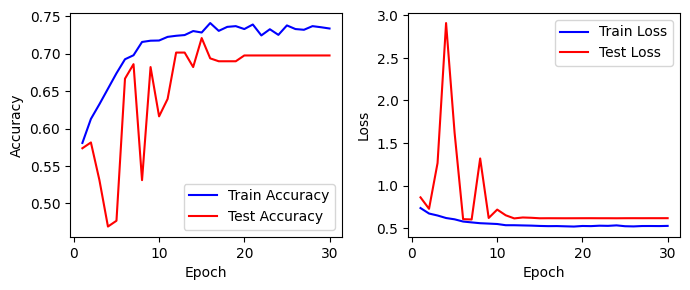

In [30]:
acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1,len(acc2)+1)
 
# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
 
axes[0].plot(epochs, acc2,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
 
axes[1].plot(epochs, loss2,'b',label='Train Loss')
axes[1].plot(epochs, val_loss,'r',label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
 
# Adjusting layout for better spacing
plt.tight_layout()
 
# Display the figure
plt.show()

In [16]:
loss, accuracy = model.evaluate(x_test,y_test)
print(f'Test Accuracy {accuracy*100:.2f}%')

9/9 [==============================] - 12s 1s/step - loss: 0.6166 - accuracy: 0.6977
Test Accuracy 69.77%


In [17]:
model.save('ResNet3_Final_Model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
import pickle

# Save the history object
with open('history_ResNet3_Final.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
model_reget = tf.keras.models.load_model('ResNet3_Final_Model.h5')

# Print model summary
model_reget.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23850625 (90.98 MB)
Trainable params: 262657 (1.00 MB)
Non-trainable params: 23587968 (89.98 MB)
_________

9/9 [==============================] - 13s 1s/step


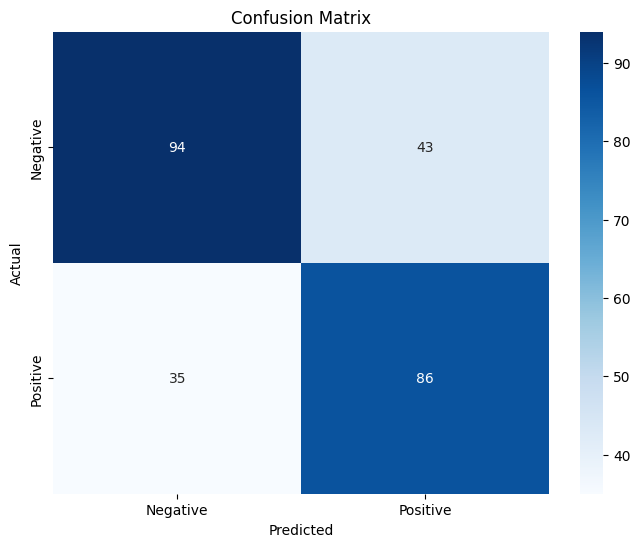

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = model_reget.predict(x_test)
y_pred_classes = np.round(y_pred).astype(int)  # Convert predictions to binary classes

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
import numpy as np
from sklearn.metrics import classification_report

# Make predictions on the test set
predict_x = model_reget.predict(x_test)
predict1 = (predict_x > 0.5).astype(int)  # Convert probabilities to binary class labels

# Print the predicted classes
print(predict1.flatten())

# Generate the classification report
target_names = ["Class 0", "Class 1"]
print(classification_report(y_test, predict1, target_names=target_names))

9/9 [==============================] - 12s 1s/step
[0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1
 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0
 0 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0
 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0
 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0
 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 1]
              precision    recall  f1-score   support

     Class 0       0.73      0.69      0.71       137
     Class 1       0.67      0.71      0.69       121

    accuracy                           0.70       258
   macro avg       0.70      0.70      0.70       258
weighted avg       0.70      0.70      0.70       258



In [12]:
import pickle
with open('history_ResNet3_Final.pkl', 'rb') as file:
    history_reget = pickle.load(file)

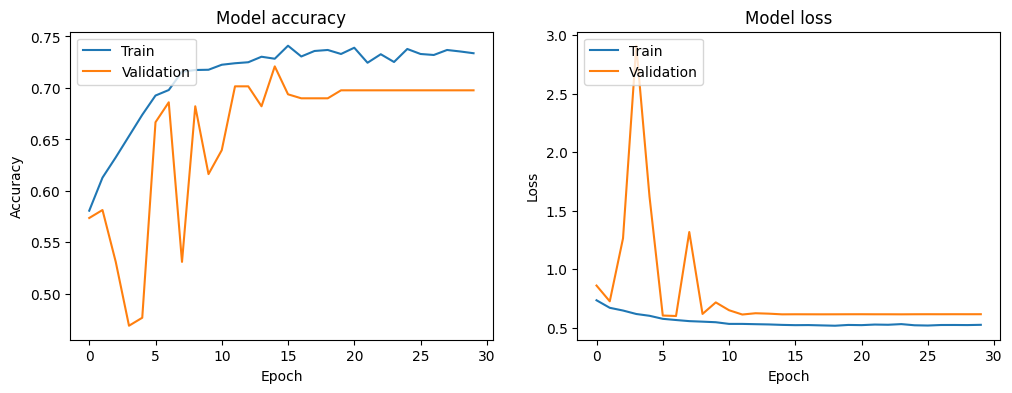

In [13]:
# reget history to plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_reget['accuracy'])
plt.plot(history_reget['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_reget['loss'])
plt.plot(history_reget['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()